In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
test_month = pd.read_csv('Basic - Azrieli & Sons data/trips_data/april 2015_4781353.csv')
test_month.head()

,Unnamed: 0,customer,driver_id,end_time,km,start_time
0,0,iaf,570,2015-04-01 09:36:00,672.312716,2015-04-01 01:55:00
1,1,yes,822,2015-04-01 16:17:00,96.048221,2015-04-01 15:12:00
2,2,intel,437,2015-04-02 04:15:00,90.727997,2015-04-02 02:49:00
3,3,yes,70,2015-04-02 15:41:00,216.595350,2015-04-02 12:41:00
4,4,jerusalem_muni,446,NaN,96.437630,2015-04-03 00:15:00


In [120]:
import os
import pandas as pd
import re
import tqdm

# Directory containing the files
directory = 'Basic - Azrieli & Sons data/trips_data'

# Initialize an empty list to store the data
data = []
processed_files = set()

average_speed = 70  # km/h
 
# Define night and weekend conditions
def is_night(time):
    hour = time.hour
    return hour >= 22 or hour < 6

def is_weekend(date):
    shishi = date.hour >= 14 and date.weekday() == 4
    shabat = date.hour < 20 and date.weekday() == 5
    return shishi or shabat

def calculate_bonuses(start_time, end_time):
    total_time = end_time - start_time
    
    night_time = timedelta(0)
    weekend_time = timedelta(0)
    
    if is_night(start_time):
        night_end = start_time.replace(hour=6, minute=0, second=0, microsecond=0)
        if night_end <= start_time:
            night_end += timedelta(days=1)
        night_time += min(end_time, night_end) - start_time

    if is_night(end_time):
        night_start = end_time.replace(hour=22, minute=0, second=0, microsecond=0)
        if night_start >= end_time:
            night_start -= timedelta(days=1)
        night_time += end_time - max(start_time, night_start)
    
    if is_weekend(start_time):
        weekend_end = start_time.replace(hour=20, minute=0, second=0, microsecond=0) + timedelta(days=(5 - start_time.weekday()) % 7)
        weekend_time += min(end_time, weekend_end) - start_time

    if is_weekend(end_time):
        weekend_start = end_time.replace(hour=14, minute=0, second=0, microsecond=0) - timedelta(days=(end_time.weekday() - 4) % 7)
        weekend_time += end_time - max(start_time, weekend_start)
    
    night_bonus = night_time / total_time
    weekend_bonus = weekend_time / total_time
    
    return night_bonus, weekend_bonus

# Iterate over each file in the directory
for filename in tqdm.tqdm(os.listdir(directory)):
    if filename.endswith(".csv"):
        # Use a regex to remove suffixes like '(2)'
        base_name = re.sub(r'\(\d+\)', '', filename)

        # Skip processing if this base name has already been processed
        if base_name in processed_files:
            continue

        processed_files.add(base_name)
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, header=0)

        df['Driver_id'] = df['driver_id']
        df['Company'] = df['customer']
        df['Kilometers'] = df['km']
        df['Month'] = pd.to_datetime(df['start_time']).dt.strftime('%m/%Y')

        df['Start_time'] = pd.to_datetime(df['start_time'])
        df['End_time'] = pd.to_datetime(df['end_time'])        
        
        condition = df['Start_time'].isna() | df['Start_time'].isin([np.nan, np.inf, -np.inf, 'nan', 'NaN'])
        df['Start_time'] = np.where(condition,
                            df['End_time'] - pd.to_timedelta(df['Kilometers'] / average_speed, unit='h'), df['Start_time'])
        condition = df['End_time'].isna() | df['End_time'].isin([np.nan, np.inf, -np.inf, 'nan', 'NaN'])            
        df['End_time'] = np.where(condition,
                            df['Start_time'] + pd.to_timedelta(df['Kilometers'] / average_speed, unit='h'), df['End_time'])
                
        df['Night_bonus'], df['Weekend_bonus'] = zip(*df.apply(lambda row: calculate_bonuses(row['Start_time'], row['End_time']), axis=1))
        data.append(df[['Driver_id', 'Month', 'Company', 'Kilometers', 'Night_bonus', 'Weekend_bonus', 'Start_time', 'End_time']])

summary_df = pd.concat(data)
print(summary_df)

 16%|█▌        | 993/6111 [00:09<00:46, 110.62it/s]C:\Users\edeng\AppData\Local\Temp\ipykernel_13700\2829056329.py:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['End_time'] = pd.to_datetime(df['end_time'])
100%|██████████| 6111/6111 [01:02<00:00, 97.39it/s] 


    Driver_id    Month         Company   Kilometers  Night_bonus  \
0         570  04/2015             iaf   672.312716     0.531453   
1         822  04/2015             yes    96.048221     0.000000   
2         437  04/2015           intel    90.727997     2.000000   
3          70  04/2015             yes   216.595350     0.000000   
4         446  04/2015  jerusalem_muni    96.437630     2.000000   
..        ...      ...             ...          ...          ...   
49        549  09/2015             iaf   338.646624     0.000000   
50        398  09/2015             yes   690.632760     0.733193   
51        924  09/2015           tnuva    74.532361     0.000000   
52        884  09/2015            tara   534.599297     0.944149   
53        901  09/2015             yes  3129.821745     0.158056   

    Weekend_bonus          Start_time                      End_time  
0             0.0 2015-04-01 01:55:00 2015-04-01 09:36:00.000000000  
1             0.0 2015-04-01 15:12:00 2015-

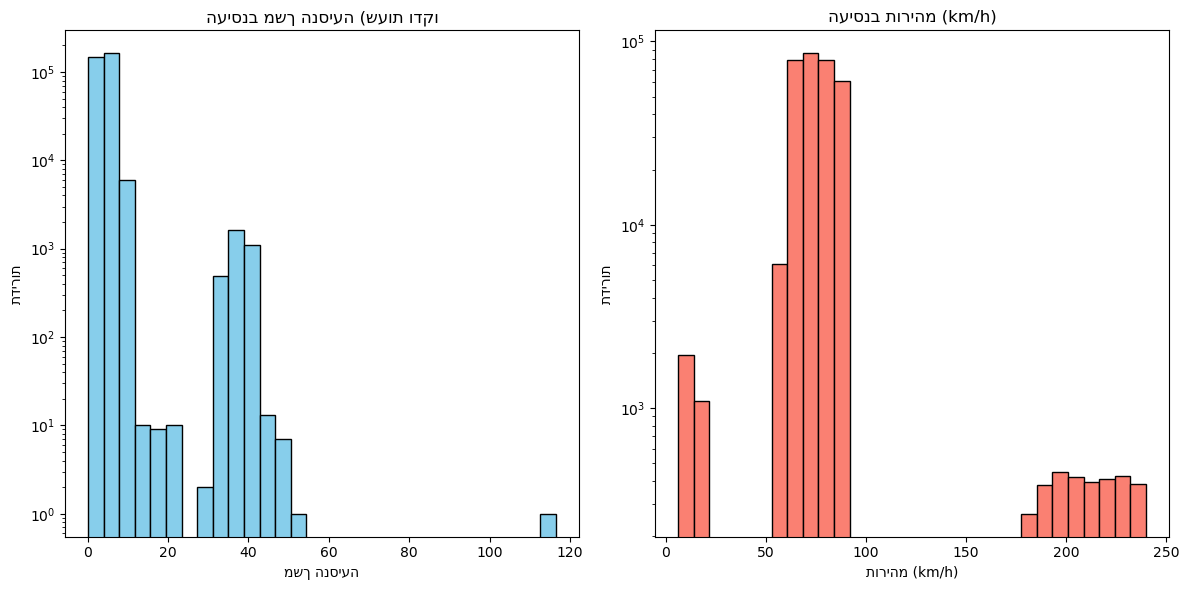

In [121]:
summary_df['Duration_hours'] = (summary_df['End_time'] - summary_df['Start_time']).dt.total_seconds() / 3600
summary_df['Average_speed'] = summary_df['Kilometers'] / summary_df['Duration_hours']

plt.figure(figsize=(12, 6))

# Plot duration hours
plt.subplot(1, 2, 1)
plt.hist(summary_df['Duration_hours'], bins=30, color='skyblue', edgecolor='black', log=True)
plt.xlabel('משך הנסיעה')
plt.ylabel('תדירות')
plt.title('העיסנב משך הנסיעה (שעות ודקו')

# Plot average speed
plt.subplot(1, 2, 2)
plt.hist(summary_df['Average_speed'], bins=30, color='salmon', edgecolor='black', log=True)
plt.xlabel('תוריהמ (km/h)')
plt.ylabel('תדירות')
plt.title('העיסנב תוריהמ (km/h)')

plt.tight_layout()
plt.show()

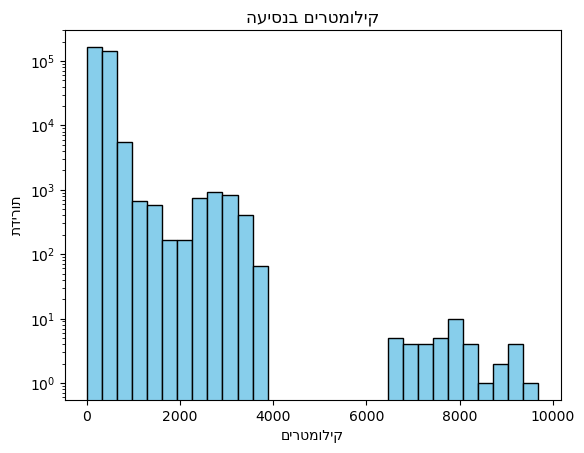

In [122]:
plt.hist(summary_df['Kilometers'], bins=30, color='skyblue', edgecolor='black', log=True)
plt.xlabel('םירטמוליק')
plt.ylabel('תדירות')
plt.title('העיסנב םירטמוליק')
plt.show()

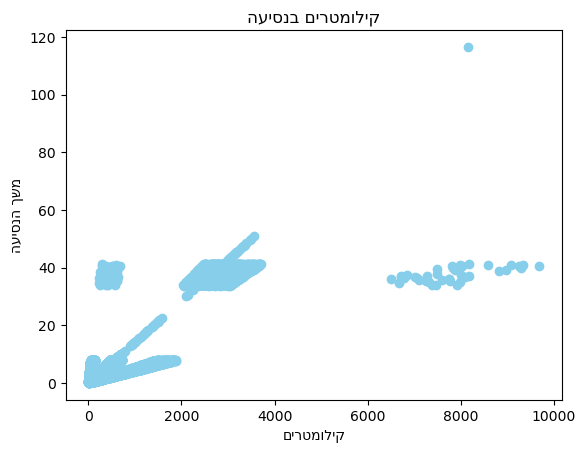

In [123]:
plt.scatter(summary_df['Kilometers'], summary_df['Duration_hours'], color='skyblue')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()

In [124]:
temp_sum = summary_df

In [125]:
summary_df = temp_sum

In [126]:
summary_df.loc[summary_df['Kilometers'] > 6000, 'Kilometers'] = summary_df.loc[summary_df['Kilometers'] > 6000, 'Kilometers'] / 10

In [127]:
summary_df.loc[(summary_df['Duration_hours'] > 30) & (summary_df['Kilometers'] < 1000), 'Duration_hours'] = summary_df.loc[(summary_df['Duration_hours'] > 30) & (summary_df['Kilometers'] < 1000), 'Duration_hours'] / 10

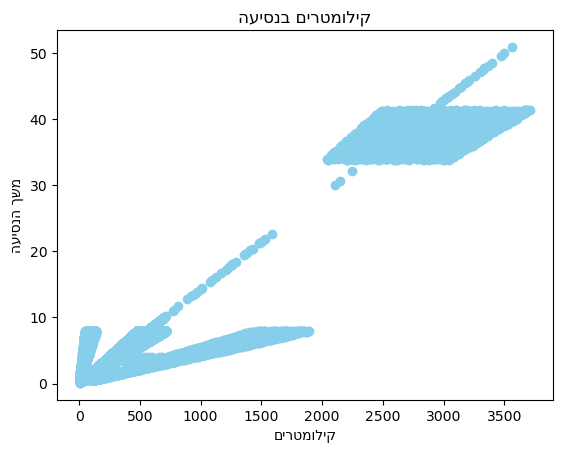

In [128]:
plt.scatter(summary_df['Kilometers'], summary_df['Duration_hours'], color='skyblue')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()

In [129]:
average_speed = summary_df['Average_speed'].mean()
average_speed

75.63031033643293

In [130]:
tariff = pd.read_csv('Basic - Azrieli & Sons data/taarif.csv', header=0)
company_tariff = tariff[tariff['customer'] == 'osem']
company_tariff

,customer,basic_taarif,extra_milage,night_bonus,weekend_bonus
8,osem,12.0,4.0,20.0,0.0


In [131]:
summary_df['Company'].unique()

array(['iaf', 'yes', 'intel', 'jerusalem_muni', 'electricity',
       'bituch_leumi', 'aminach', 'angel', 'osem', 'tara', 'tnuva', 'hot'],
      dtype=object)

In [132]:
summary_df['Company'] = summary_df['Company'].replace({"yes": "dbs", "aminach": "mizranei_kfar_saba"}) 

In [133]:
def salary(row):
    company = row['Company']
    kilometers = row['Kilometers']
    night_bonus = row['Night_bonus']
    weekend_bonus = row['Weekend_bonus']

    company_tariff = tariff[tariff['customer'] == company]
    if company_tariff.empty:
        return 0

    base_rate = company_tariff['basic_taarif'].values[0]
    extra_rate = company_tariff['extra_milage'].values[0]
    night_rate = company_tariff['night_bonus'].values[0]
    weekend_rate = company_tariff['weekend_bonus'].values[0]

    base_kilometers = min(kilometers, 200)
    extra_kilometers = max(kilometers - 200, 0)

    night_bonus = night_bonus * night_rate
    weekend_bonus = weekend_bonus * weekend_rate

    basic_salary = base_kilometers * base_rate + extra_kilometers * extra_rate
    salary_with_bonus = basic_salary + basic_salary * night_bonus / 100 + basic_salary * weekend_bonus / 100
    
    return salary_with_bonus

In [134]:
summary_df['salary'] = summary_df.apply(salary, axis=1)
summary_df2 = summary_df
summary_df

,Driver_id,Month,Company,Kilometers,Night_bonus,Weekend_bonus,Start_time,End_time,Duration_hours,Average_speed,salary
0,570,04/2015,iaf,672.312716,0.531453,0.0,2015-04-01 01:55:00,2015-04-01 09:36:00.000000000,7.683333,87.502740,17994.997679
1,822,04/2015,dbs,96.048221,0.000000,0.0,2015-04-01 15:12:00,2015-04-01 16:17:00.000000000,1.083333,88.659896,960.482210
2,437,04/2015,intel,90.727997,2.000000,0.0,2015-04-02 02:49:00,2015-04-02 04:15:00.000000000,1.433333,63.298603,1016.153571
3,70,04/2015,dbs,216.595350,0.000000,0.0,2015-04-02 12:41:00,2015-04-02 15:41:00.000000000,3.000000,72.198450,2132.762801
4,446,04/2015,jerusalem_muni,96.437630,2.000000,0.0,2015-04-03 00:15:00,2015-04-03 01:37:39.649531008,1.377680,70.000000,1543.002076
...,...,...,...,...,...,...,...,...,...,...,...
49,549,09/2015,iaf,338.646624,0.000000,2.0,2015-09-25 14:02:00,2015-09-25 18:41:00.000000000,4.650000,72.827231,59251.128608
50,398,09/2015,dbs,690.632760,0.733193,2.0,2015-09-26 00:11:00,2015-09-26 08:07:00.000000000,7.933333,87.054550,8887.593124
51,924,09/2015,tnuva,74.532361,0.000000,2.0,2015-09-26 15:12:00,2015-09-26 16:13:00.000000000,1.016667,73.310519,447.194166
52,884,09/2015,tara,534.599297,0.944149,0.0,2015-09-27 00:05:00,2015-09-27 06:21:00.000000000,6.266667,85.308398,4721.819853


In [135]:
old_drivers_info = pd.read_csv('Basic - Azrieli & Sons data/Drivers_with_kviut.csv', header=0)
new_drivers_info = pd.read_csv('Basic - Azrieli & Sons data/new_drivers.csv', header=0)

# keep only one digit after point
new_drivers_info['vetek'] = (new_drivers_info['vetek'] / 365).round(1) 

drivers_info = pd.concat([old_drivers_info, new_drivers_info])
drivers_info

,Unnamed: 0,birthdate,gender,id,vetek
0,100,27/05/1964,m,502,7.9
1,101,10/07/1983,M,81,14.4
2,102,15/10/1992,M,814,18.7
3,103,18/07/1990,M,666,8.7
4,104,10/04/1969,M,205,9.9
...,...,...,...,...,...
95,95,16/08/1990,M,798,0.4
96,96,05/06/1967,M,865,0.3
97,97,02/10/1972,M,399,0.9
98,98,16/03/1979,M,509,0.5


In [136]:
drivers_info['gender'].unique()

array(['m', 'M', 'girl', 'male', 'unknown', 'F', 'none', 'female', 'boy',
       nan, 'woman'], dtype=object)

In [137]:
gender_map = {'m': 'M', 'M': 'M', 'male': 'M', 'boy': 'M', 'girl': 'F', 'female': 'F', 'F': 'F', 'unknown': 'unknown', 'none': 'unknown', np.nan: 'unknown', 'NaN': 'unknown', None: 'unknown'}
drivers_info['gender'] = drivers_info['gender'].map(gender_map)
drivers_info['gender'].unique()

array(['M', 'F', 'unknown', nan], dtype=object)

In [138]:
def parse_date(date_str):
    formats = ['%d/%m/%Y', '%B %d, %Y']
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return None

drivers_info['parsed_dates'] = drivers_info['birthdate'].apply(lambda x: parse_date(x) if pd.notnull(x) else None)
drivers_info

,Unnamed: 0,birthdate,gender,id,vetek,parsed_dates
0,100,27/05/1964,M,502,7.9,1964-05-27
1,101,10/07/1983,M,81,14.4,1983-07-10
2,102,15/10/1992,M,814,18.7,1992-10-15
3,103,18/07/1990,M,666,8.7,1990-07-18
4,104,10/04/1969,M,205,9.9,1969-04-10
...,...,...,...,...,...,...
95,95,16/08/1990,M,798,0.4,1990-08-16
96,96,05/06/1967,M,865,0.3,1967-06-05
97,97,02/10/1972,M,399,0.9,1972-10-02
98,98,16/03/1979,M,509,0.5,1979-03-16


In [139]:
def calculate_age(birthdate):
    if birthdate is None:
        return 'Unknown'
    today = datetime.today()
    age = (today - birthdate).days / 365
    if age > 100 or age < 0 or age in [np.nan, np.inf, -np.inf, 'nan', 'NaN']:
        return 'Unknown'
    return f"{age:.1f}"

drivers_info['age'] = drivers_info['parsed_dates'].apply(calculate_age)

drivers_info

,Unnamed: 0,birthdate,gender,id,vetek,parsed_dates,age
0,100,27/05/1964,M,502,7.9,1964-05-27,60.3
1,101,10/07/1983,M,81,14.4,1983-07-10,41.1
2,102,15/10/1992,M,814,18.7,1992-10-15,31.8
3,103,18/07/1990,M,666,8.7,1990-07-18,34.1
4,104,10/04/1969,M,205,9.9,1969-04-10,55.4
...,...,...,...,...,...,...,...
95,95,16/08/1990,M,798,0.4,1990-08-16,34.0
96,96,05/06/1967,M,865,0.3,1967-06-05,57.2
97,97,02/10/1972,M,399,0.9,1972-10-02,51.9
98,98,16/03/1979,M,509,0.5,1979-03-16,45.4


In [140]:
drivers_info.drop(columns=['birthdate', 'parsed_dates'], inplace=True)
drivers_info.replace({'nan': 'Unknown'}, inplace=True)
drivers_info.fillna('Unknown', inplace=True)
drivers_info.set_index('id', inplace=True)
drivers_info

,Unnamed: 0,gender,vetek,age
id,,,,
502,100,M,7.9,60.3
81,101,M,14.4,41.1
814,102,M,18.7,31.8
666,103,M,8.7,34.1
205,104,M,9.9,55.4
...,...,...,...,...
798,95,M,0.4,34.0
865,96,M,0.3,57.2
399,97,M,0.9,51.9


In [141]:
summary_df = summary_df.drop(columns=['Night_bonus', 'Weekend_bonus', 'Company', 'Duration_hours', 'Average_speed', 'Start_time', 'End_time'])
summary_df

,Driver_id,Month,Kilometers,salary
0,570,04/2015,672.312716,17994.997679
1,822,04/2015,96.048221,960.482210
2,437,04/2015,90.727997,1016.153571
3,70,04/2015,216.595350,2132.762801
4,446,04/2015,96.437630,1543.002076
...,...,...,...,...
49,549,09/2015,338.646624,59251.128608
50,398,09/2015,690.632760,8887.593124
51,924,09/2015,74.532361,447.194166
52,884,09/2015,534.599297,4721.819853


In [142]:
summary_df.rename(columns={'Kilometers': 'Total_km', "salary": "Total_income"}, inplace=True)
grouped_df = summary_df.groupby(['Driver_id', 'Month'], as_index='True').sum()
grouped_df

Total_km   Total_income
Driver_id Month                               
1         01/2015  11246.923101  171914.338738
          02/2015   6257.774039   71252.619852
          03/2015   9501.577407  191076.709716
          04/2015   6938.816287   95856.650696
          05/2015  12152.974323  126474.836466
...                         ...            ...
1000      08/2015   7974.440208   73435.046745
          09/2015   9000.962217  238098.438338
          10/2015   8966.795284  139646.685669
          11/2015  10143.821127  137039.048097
          12/2015   7537.938484   70193.734890

[12000 rows x 2 columns]

In [143]:
grouped_df.index.names = ['id', 'Month']
grouped_df

Total_km   Total_income
id   Month                               
1    01/2015  11246.923101  171914.338738
     02/2015   6257.774039   71252.619852
     03/2015   9501.577407  191076.709716
     04/2015   6938.816287   95856.650696
     05/2015  12152.974323  126474.836466
...                    ...            ...
1000 08/2015   7974.440208   73435.046745
     09/2015   9000.962217  238098.438338
     10/2015   8966.795284  139646.685669
     11/2015  10143.821127  137039.048097
     12/2015   7537.938484   70193.734890

[12000 rows x 2 columns]

In [144]:
final_df = grouped_df.join(drivers_info, how='inner')
final_df

Total_km   Total_income  Unnamed: 0 gender  vetek   age
id   Month                                                               
1    01/2015  11246.923101  171914.338738         766      F    1.4  42.5
     02/2015   6257.774039   71252.619852         766      F    1.4  42.5
     03/2015   9501.577407  191076.709716         766      F    1.4  42.5
     04/2015   6938.816287   95856.650696         766      F    1.4  42.5
     05/2015  12152.974323  126474.836466         766      F    1.4  42.5
...                    ...            ...         ...    ...    ...   ...
1000 08/2015   7974.440208   73435.046745         260      M    4.0  44.0
     09/2015   9000.962217  238098.438338         260      M    4.0  44.0
     10/2015   8966.795284  139646.685669         260      M    4.0  44.0
     11/2015  10143.821127  137039.048097         260      M    4.0  44.0
     12/2015   7537.938484   70193.734890         260      M    4.0  44.0

[12000 rows x 6 columns]

In [145]:
final_df.drop('Unnamed: 0', axis=1, inplace=True)

In [146]:
final_df.to_csv('Basic - Azrieli & Sons data/summary.csv')

In [147]:
id_df = final_df.droplevel(1)
id_df

,Total_km,Total_income,gender,vetek,age
id,,,,,
1,11246.923101,171914.338738,F,1.4,42.5
1,6257.774039,71252.619852,F,1.4,42.5
1,9501.577407,191076.709716,F,1.4,42.5
1,6938.816287,95856.650696,F,1.4,42.5
1,12152.974323,126474.836466,F,1.4,42.5
...,...,...,...,...,...
1000,7974.440208,73435.046745,M,4.0,44.0
1000,9000.962217,238098.438338,M,4.0,44.0
1000,8966.795284,139646.685669,M,4.0,44.0


In [148]:
avg_km_a_month = final_df.groupby('id')['Total_km'].mean()
avg_km_a_month

id
1       9322.812263
2       9554.862888
3       9160.183952
4       8846.608863
5       9035.257165
           ...     
996     8775.667283
997     8879.545664
998     8645.128210
999     8795.322867
1000    8901.339767
Name: Total_km, Length: 1000, dtype: float64

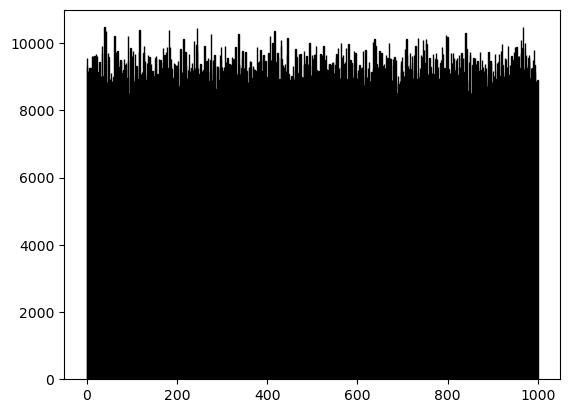

In [149]:
plt.bar(range(len(avg_km_a_month)), avg_km_a_month, color='skyblue', edgecolor='black')
plt.show()

In [150]:
avg_km_a_month.mean()

9083.650132927749

In [151]:
summary_df.groupby(['Driver_id', 'Month']).count().mean()  # how many days do they work?

Total_km        26.252667
Total_income    26.252667
dtype: float64

In [152]:
avg_km_a_day = avg_km_a_month / 26.25
avg_km_a_day

id
1       355.154753
2       363.994777
3       348.959389
4       337.013671
5       344.200273
           ...    
996     334.311135
997     338.268406
998     329.338218
999     335.059919
1000    339.098658
Name: Total_km, Length: 1000, dtype: float64

In [153]:
time_a_day = avg_km_a_day / average_speed
time_a_day

id
1       4.695931
2       4.812816
3       4.614015
4       4.456066
5       4.551089
          ...   
996     4.420333
997     4.472657
998     4.354580
999     4.430233
1000    4.483634
Name: Total_km, Length: 1000, dtype: float64

In [154]:
time_a_day.mean()

4.575464691978478

In [155]:
summary_df2['Duration_hours'].mean()

4.57636729842168

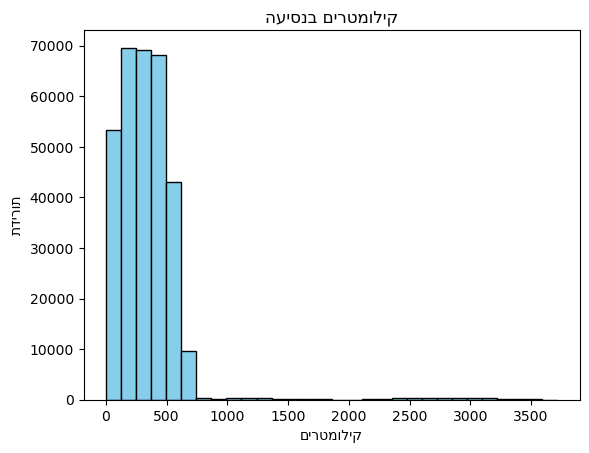

In [156]:
plt.hist(summary_df2['Kilometers'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('םירטמוליק')
plt.ylabel('תדירות')
plt.title('העיסנב םירטמוליק')
plt.show()

Text(0.5, 1.0, 'העיסנב תוריהמ (km/h)')

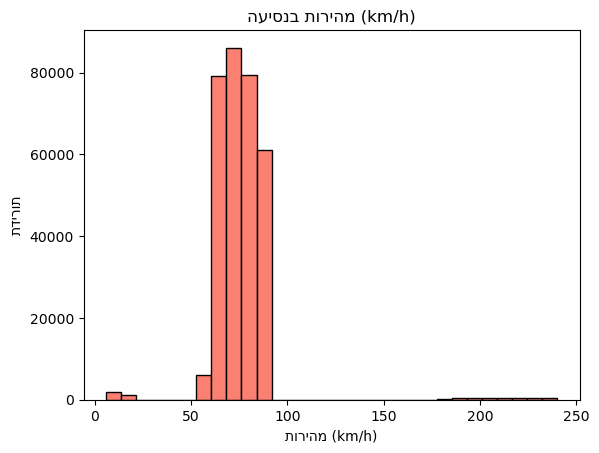

In [157]:
plt.hist(summary_df2['Average_speed'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('תוריהמ (km/h)')
plt.ylabel('תדירות')
plt.title('העיסנב תוריהמ (km/h)')

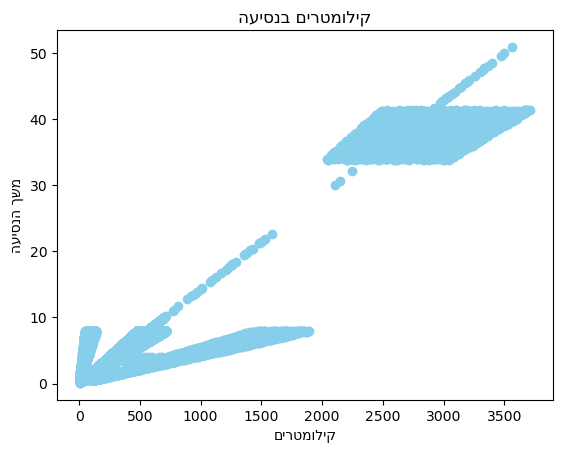

In [158]:
plt.scatter(summary_df2['Kilometers'], summary_df2['Duration_hours'], color='skyblue')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()

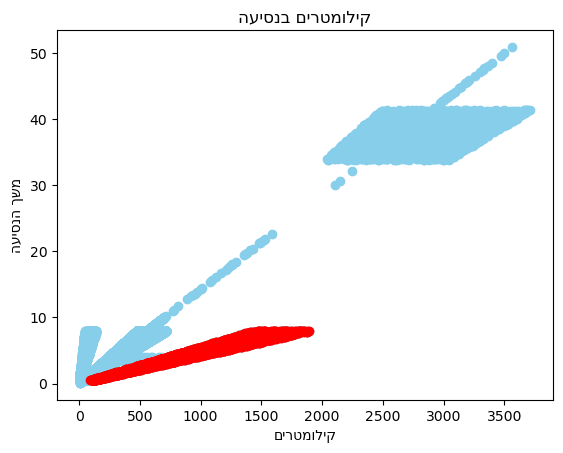

In [159]:
summary_df3 = summary_df2[summary_df2['Kilometers']/summary_df2['Duration_hours'] > 180]
plt.scatter(summary_df2['Kilometers'], summary_df2['Duration_hours'], color='skyblue')
plt.scatter(summary_df3['Kilometers'], summary_df3['Duration_hours'], color='red')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()

In [160]:
summary_df2.loc[summary_df2['Kilometers']/summary_df2['Duration_hours'] > 180, 'Kilometers'] = summary_df2.loc[summary_df2['Kilometers']/summary_df2['Duration_hours'] > 180, 'Kilometers'] / 10


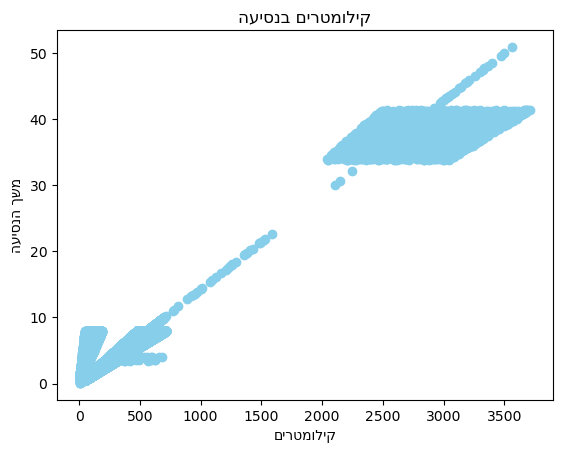

In [161]:
plt.scatter(summary_df2['Kilometers'], summary_df2['Duration_hours'], color='skyblue')
# plt.scatter(summary_df3['Kilometers'], summary_df3['Duration_hours'], color='red')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()

In [163]:
summary_df2.loc[summary_df2['Kilometers']/summary_df2['Duration_hours'] < 30, 'Duration_hours'] = summary_df2.loc[summary_df2['Kilometers']/summary_df2['Duration_hours'] < 30, 'Duration_hours'] /10   

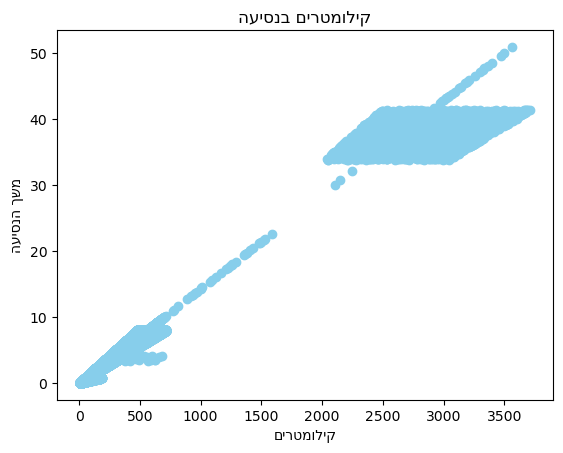

In [164]:
plt.scatter(summary_df2['Kilometers'], summary_df2['Duration_hours'], color='skyblue')
# plt.scatter(summary_df2[summary_df2['Kilometers']/summary_df2['Duration_hours'] < 30]['Kilometers'],
#             summary_df2[summary_df2['Kilometers']/summary_df2['Duration_hours'] < 30]['Duration_hours'],color='red')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()

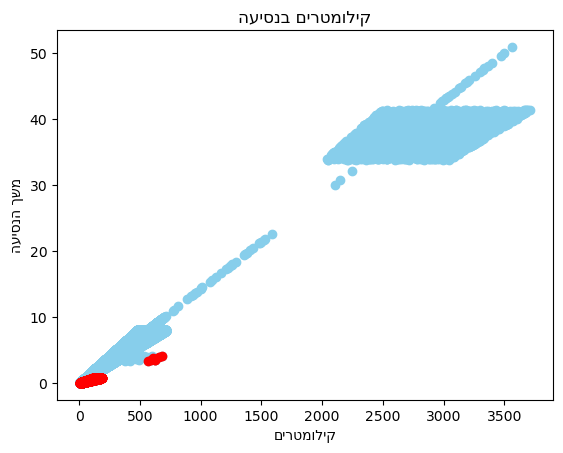

In [166]:
plt.scatter(summary_df2['Kilometers'], summary_df2['Duration_hours'], color='skyblue')
plt.scatter(summary_df2[summary_df2['Kilometers']/summary_df2['Duration_hours'] > 150]['Kilometers'],
            summary_df2[summary_df2['Kilometers']/summary_df2['Duration_hours'] > 150]['Duration_hours'],color='red')
plt.xlabel('םירטמוליק')
plt.ylabel('העיסנה ךשמ')
plt.title('העיסנב םירטמוליק')
plt.show()